<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [ ]:
#@title Current Date
Today = '2021-10-05' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [191]:
# standard libraries
import warnings
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import os

# SKlearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
    classification_report,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek


# NLP libraries
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

# For plotting
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import jupyterthemes.jtplot as jt

# jt.style(theme="monokai")
random_state = 35848
np.random.seed(random_state)
warnings.filterwarnings("ignore")


%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Loading and preparing training data

In [2]:
dir_path = os.path.join(os.getcwd(), "house_prices")
train_fname = "HousePrice_Train.csv"
test_fname = "HousePrice_Test.csv"

train_set = (
    pd.read_csv(os.path.join(dir_path, train_fname),)
    .rename(columns=lambda x: x.lower())
    .set_index("index")
    .drop(columns="id")
)
print("Loaded training set of shape", train_set.shape)


test_set = (
    pd.read_csv(os.path.join(dir_path, test_fname),)
    .rename(columns=lambda x: x.lower())
    .set_index("index")
    .drop(columns="id")
)
print("Loaded training set of shape", test_set.shape)

Loaded training set of shape (1638, 12)
Loaded training set of shape (702, 11)


### Examining missing data
Check the number of missing entries in the training set

In [3]:
train_set.isna().sum()

location            0
num_bathrooms       0
num_beds            0
ber_class         251
description         0
services         1061
features            0
latitude            0
longitude           0
type                0
surface             0
price               0
dtype: int64

While the above shows we don't have many missing values, this is actually incorrect! The text columns have entries with "None" as strings instead of `None`, we need to replace these. 

I'll also drop `location` as this will already be represented by the `latitude` and `longitude` features

In [4]:
string_features = train_set.select_dtypes("object").copy()
string_features = string_features.where(string_features != "None", None)

train_set.drop(columns=string_features.columns, inplace=True)
train_set = pd.concat([train_set, string_features], axis=1).drop(columns="location")
train_set.isna().sum()

num_bathrooms       0
num_beds            0
latitude            0
longitude           0
surface             0
price               0
ber_class         251
description         0
services         1061
features          516
type                0
dtype: int64

## Examining outliers
Next let's try to identify outliers.

Numeric columns: ['num_bathrooms', 'num_beds', 'latitude', 'longitude', 'surface', 'price']


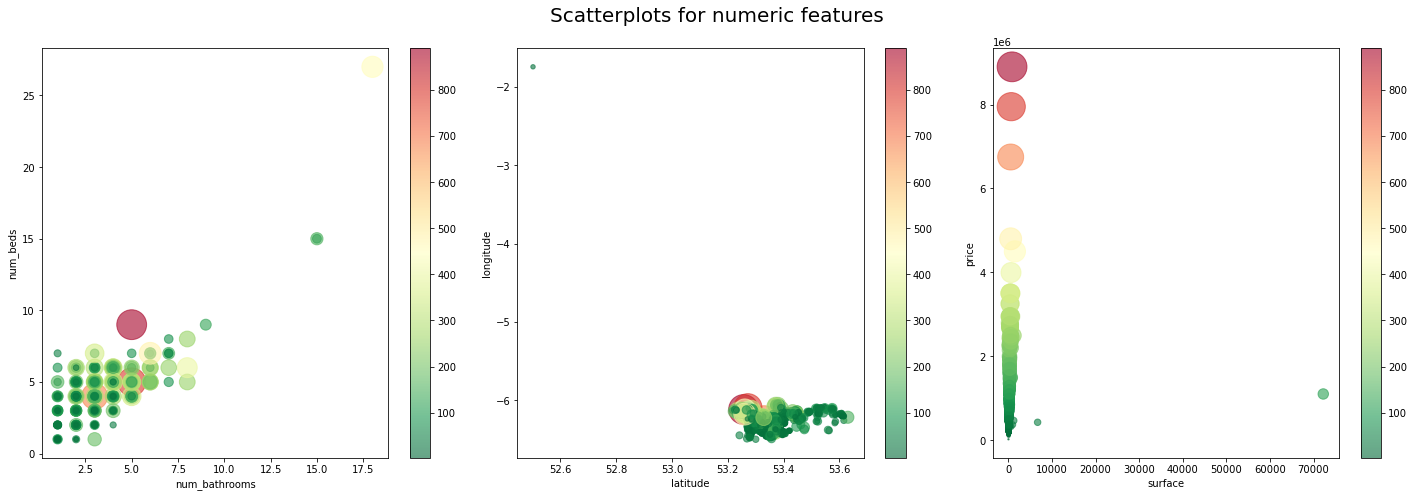

In [22]:
def plot_numeric_feats(dataset, cmap=get_cmap("RdYlGn").reversed(), scale_price=False):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    if scale_price:
        scaled_price = dataset["price"] / 10_000
    else:
        scaled_price = dataset["price"]

    dataset[["num_bathrooms", "num_beds", "price"]].plot.scatter(
        "num_bathrooms",
        "num_beds",
        s=scaled_price,
        ax=axes[0],
        alpha=0.6,
        c=scaled_price,
        cmap=cmap,
    )
    dataset[["latitude", "longitude", "price"]].plot.scatter(
        "latitude",
        "longitude",
        s=scaled_price,
        ax=axes[1],
        alpha=0.6,
        c=scaled_price,
        cmap=cmap,
    )
    dataset[["surface", "price"]].plot.scatter(
        "surface",
        "price",
        s=scaled_price,
        ax=axes[2],
        alpha=0.6,
        c=scaled_price,
        cmap=cmap,
    )
    fig.suptitle("Scatterplots for numeric features", size=20)
    fig.tight_layout()
    plt.show()


print("Numeric columns:", train_set.select_dtypes(["int", "float"]).columns.tolist())
plot_numeric_feats(train_set, scale_price=True)

The scatterplots indicate the presences of a few outliers in the numeric features, let's examine them

In [6]:
bathroom_mask = train_set["num_bathrooms"] > 10
longitude_mask = train_set["longitude"] > -5
surface_mask = train_set["surface"] > 5_000

train_set_outliers = train_set[bathroom_mask | longitude_mask | surface_mask]
pd.set_option("max_colwidth", 200)
train_set_outliers.drop(columns=["services"])

,num_bathrooms,num_beds,latitude,longitude,surface,price,ber_class,description,features,type
index,,,,,,,,,,
356,1,3,52.501856,-1.744995,79.00000,199000,NaN,"RAY COOKE AUCTIONEERS take great pleasure in introducing this stunning three bedroom semi-detached family home to the market on Wheatfield Close, Dublin 22. \n\nThis ever sought after location is ...",None,semi-detached
507,1,4,53.474502,-6.343483,72236.38714,1100000,E1,Thornton Park is a superb modern equestrian centre offering top class facilities in a beautiful setting on approximately 17.85 acres located 25 minutes from Dublin s City Centre.\n\nThe state of t...,None,bungalow
558,15,15,53.335109,-6.331515,318.20000,775000,D1,"umber 67 &amp; 69 Jamestown Road represent a fantastic investment opportunity to the discerning investor bringing a previous rent roll of €106,600 which can be improved upon. Ideally located on a ...","18 separate units\nTransport links including the LUAS\nStriking distance of the city centre\nRent roll €106,600\nIn the heart of the village\nLane access\n",semi-detached
1100,15,15,53.287504,-6.146605,700.00000,1500000,NaN,A truly unique stone built house of great quality totalling approx. 700 sq.m/7534 sq.ft steeped in history and built on the original lands of Monkstown Castle in 1859 for the honourable J.W Vesey ...,Lift servicing all floors\nVenetian and gothic influences throughout\nArchitect designed by Dean and Woodward in 1858\nUsed previously both as a guest house and a nursing home\nAmple off street pa...,detached
1116,1,2,53.386540,-6.377356,6705.00000,425000,E2,"Baxter Real Estate are delighted to present to the market, this detached bungalow located on Main Street, Blanchardstown. Most recently used as a dental surgery, this property extends to approxima...","Short drive to the N3 and M50 .\nSuitable for residential use, subject to planing permission.\nWithin walking distance of Blanchardstown Shopping Centre and beside Supervalu Blanchardstown.\nDetac...",bungalow
1379,18,27,53.260955,-6.117266,1490.00000,4500000,NaN,The Grove is an imposing Victorian mansion built c.1840 situated on approximately 0.88 ha / 2.17 acres of mature elevated grounds with outstanding sea views across Killiney Bay. With accommodation...,Approx. 1 490 sq. m / 16 041 sq. ft. of accommodation over four floors\nSituated on mature grounds of approximately 0.88 ha / 2.17 acres\nAbundance of period features\nOutstanding sea views across...,detached


### Outlier analysis
- index 356 : Has incorrect latitude. A google maps search shows this location is in Birmingham, UK
- index 507 : Is not a house but an equestrian centre with 17 acres
- index 558 : 15 beds and bathrooms shows that is actually a number of units
- index 1100 : Is actually fine, the house is just a big mansion.
- index 1116 : Incorrect value for surface, the description shows it is 67.5sqm
- index 1379 : Another mansion

Overall the first three entries could be removed from the dataset for showing poor data quality and `index 1116` can be fixed manually. 

The only decision lies within leaving the two ads for mansions in the dataset or not. The scatterplot above shows that these mansions have an abnormal number of bathrooms/bedrooms when compared with the rest of the houses, hence I'll choose to remove them

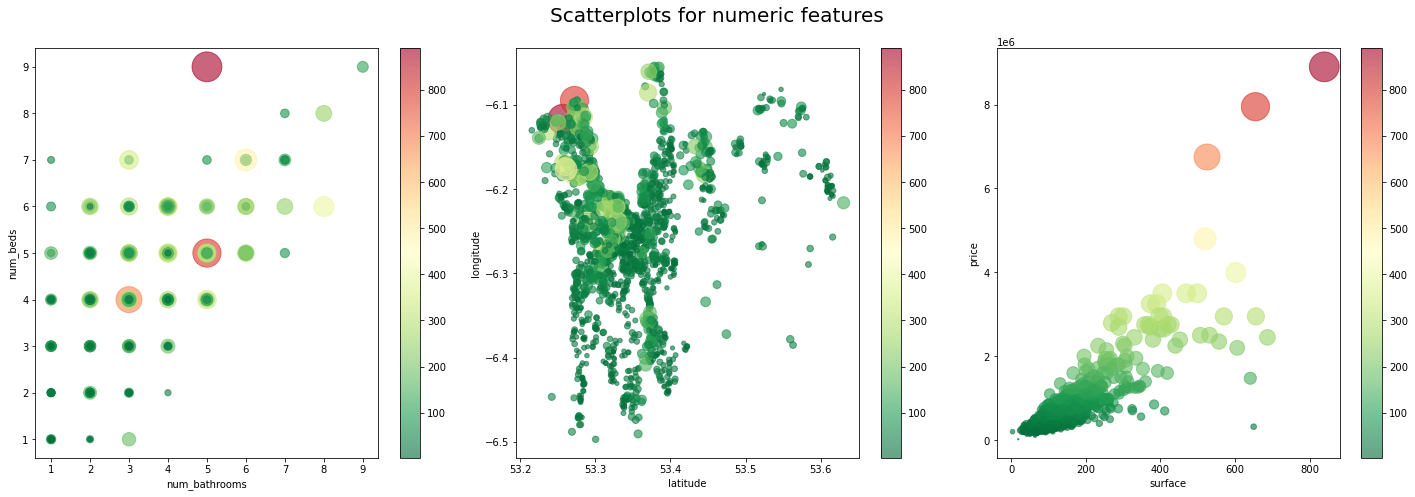

In [71]:
pd.reset_option("max_colwidth")

drop_index = [356, 507, 558, 1100, 1379]
fix_index = 1116

cleaned_train_set = train_set.drop(index=drop_index)

cleaned_train_set.loc[fix_index, "surface"] = (
    cleaned_train_set.loc[fix_index, "surface"] / 100
)
cleaned_train_set = cleaned_train_set[
    cleaned_train_set["surface"] < 900
]  # Some other outliers that need to be filtered, found via manual inspection
plot_numeric_feats(cleaned_train_set, scale_price=True)

Now the datapoints look much better distributed, let's do some feature engineering

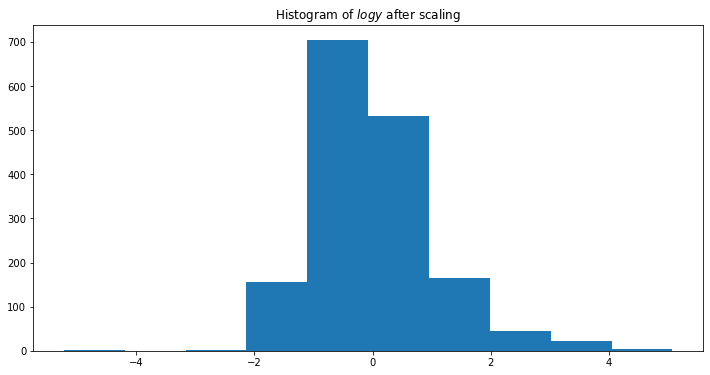

In [72]:
X, y = cleaned_train_set.drop(columns="price"), cleaned_train_set["price"]

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(np.log(y.values.reshape(-1, 1)))

plt.figure(figsize=(12, 6))
plt.title("Histogram of $log{y}$ after scaling")
plt.hist(y_scaled)
plt.show()

# Creating Numeric features

In [74]:
X_numeric = X.select_dtypes(["int", "float"])

feature_scaler = StandardScaler()
X_num_scaled = feature_scaler.fit_transform(X_numeric)

# std_num = pd.DataFrame(X_num_scaled, columns=X_numeric.columns)
# std_num["price"] = y_scaler.inverse_transform(y_scaled)
# plot_numeric_feats(std_num, scale_price=False)

# Baseline model
Let's set some baseline models that predict mean and median house price so we have a start point for our more advanced models

In [76]:
def print_evaluation(y, y_preds, model_name="Baseline Mean"):
    mae = mean_absolute_error(y, y_preds)
    msle = mean_squared_log_error(y, y_preds)
    rmsle = mean_squared_log_error(y, y_preds, squared=False)
    mape = mean_absolute_percentage_error(y, y_preds)

    print(f"------ {model_name} model performance ------")
    print(f"MAE: {mae:,.2f}")
    print(f"MSLE: {msle:,.4f}")
    print(f"RMSLE: {rmsle:,.4f}")
    print(f"MAPE: {mape:,.4f}")


def baseline_mean(y, y_scaler, evaluate=True):
    """Creates a set of predictions for X using solely the mean of training samples"""
    y_true = np.exp(y_scaler.inverse_transform(y))
    y_preds = np.exp(y_scaler.inverse_transform(np.ones(shape=(y.shape)) * np.mean(y)))

    if evaluate:
        print_evaluation(y_true, y_preds)
    return y_preds


def baseline_median(y, y_scaler, evaluate=True):
    """Creates a set of predictions for X using solely the median of training samples"""
    y_true = np.exp(y_scaler.inverse_transform(y))
    y_preds = np.exp(
        y_scaler.inverse_transform(np.ones(shape=(y.shape)) * np.median(y))
    )

    if evaluate:
        print_evaluation(y_true, y_preds)
    return y_preds

In [77]:
train_price = cleaned_train_set["price"].to_numpy().reshape(-1, 1)

y_train_mean = baseline_mean(y_scaled, y_scaler)
y_train_median = baseline_median(y_scaled, y_scaler, "Baseline median")

------ Baseline Mean model performance ------
MAE: 262,562.21
MSLE: 0.3504
RMSLE: 0.5920
MAPE: 0.4659
------ Baseline Mean model performance ------
MAE: 259,619.08
MSLE: 0.3628
RMSLE: 0.6023
MAPE: 0.4105


As expected the predictions are not great, but now we have something we can improve on

Create a dummy submission using these models

In [79]:
copy = test_set.copy().reset_index().rename(columns={"index": "Index"})

y_test_mean_preds = y_train_mean[: test_set.shape[0]]
y_test_median_preds = y_train_median[: test_set.shape[0]]

copy["Price"] = y_test_mean_preds
copy[["Index", "Price"]].to_csv(
    os.path.join(dir_path, "preds/", "mean_preds.csv"), index=False
)
copy["Price"] = y_test_mean_preds
copy[["Index", "Price"]].to_csv(
    os.path.join(dir_path, "preds/", "median_preds.csv"), index=False
)

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Let's now examine text features. We already know that `ber_class` and `type` can be encoded so let's separate them.

In [80]:
encoding_features = ["ber_class", "type"]

X_txt = X.select_dtypes("object")
X_txt.sample(5, random_state=random_state)

,ber_class,description,services,features,type
index,,,,,
887,C3,Situated on a quiet lane just off the southern...,"Parking,Oil Fired Central Heating",Spacious accommodation of c.216 sq m overall w...,detached
248,C3,Doran Estates are delighted to present 7 Carri...,"Parking,Gas Fired Central Heating",Highly maintained semi detached house\nEstabli...,semi-detached
1340,G,Joseph Estates is delighted to present this wo...,"Parking,Wired for Cable Television",Top Floor Apartment \nExcellent opportunity to...,apartment
1612,F,A wonderful opportunity to acquire an imposing...,NaN,Two storey semi-detached house with garage to ...,semi-detached
1449,C3,REA Grimes are delighted to present this stunn...,NaN,.\tPristine condition throughout\n.\tWired thr...,semi-detached


There are some characters that need to be cleaned from `description` and `features`, let's remove `\n`, `\r` and variants

In [81]:
def clean_texts(series):
    """Cleans linebreaks, tabs return character, punctuation and double spacing in a Series of strings."""
    clean_series = series.copy().str.replace(r"\t|\n|\r", " ", regex=True)
    clean_series = clean_series.str.replace(r"[,.?!:;\[\]/\(\)'\"]", " ", regex=True)
    clean_series = clean_series.str.replace(r"\s+", " ", regex=True)
    return clean_series.str.lower()


def map_ber(series):
    """Removes the numerical rating for BER, yielding only the letter rating.

    I'm trying this strategy as class A1 has only one sample, which doesn't allow for 
    upsampling with SMOTE. In addition, using only a letter rating yields a smaller number
    of classes and can make the problem of estimating new BER classes easier
    """
    clean_ber = series.str.replace("SINo666of2006exempt", "EX")
    clean_ber = clean_ber.str.replace(r"\d+", "", regex=True)
    return clean_ber

In [82]:
X_txt.loc[:, "description"] = clean_texts(X_txt.loc[:, "description"])
X_txt.loc[:, "features"] = clean_texts(X_txt.loc[:, "features"])
X_txt.loc[:, "ber_class"] = map_ber(X_txt.loc[:, "ber_class"])

X_txt[["description", "features", "ber_class"]].sample(3, random_state=random_state)

,description,features,ber_class
index,,,
887,situated on a quiet lane just off the southern...,spacious accommodation of c 216 sq m overall w...,C
248,doran estates are delighted to present 7 carri...,highly maintained semi detached house establis...,C
1340,joseph estates is delighted to present this wo...,top floor apartment excellent opportunity to a...,G


In [83]:
X_txt.isna().sum()

ber_class       248
description       0
services       1056
features        512
type              0
dtype: int64

`ber_class` and `services` have many null entries, but perhaps we can use other features to estimate `ber_class`?

First we isolate the instances that have missing values and preprocess the training data by vectorizing and upsampling the targe classes

In [84]:
# Let's separate entries where ber_class is missing, we want to fill these in
missing_ber = X_txt["ber_class"].isna()
X_missing = X_txt.loc[missing_ber, "description"].copy()

X_ber = X_txt.loc[~missing_ber, "description"].copy()
y_ber = X_txt.loc[~missing_ber, "ber_class"].copy()

label_encoder = LabelEncoder()
y_ber_encoded = label_encoder.fit_transform(y_ber)

vectorizer = TfidfVectorizer()
X_ber_vec = vectorizer.fit_transform(X_ber)

smote = SMOTETomek(random_state=random_state)
X_ber_bal, y_ber_bal = smote.fit_resample(X_ber_vec, y_ber_encoded)

X_ber_train, X_ber_test, y_ber_train, y_ber_test = train_test_split(
    X_ber_bal, y_ber_bal, train_size=0.85, random_state=random_state,
)
print(f"BER training set shape: {X_ber_train.shape}")
print(f"BER test set shape: {X_ber_test.shape}")

BER training set shape: (2912, 11088)
BER test set shape: (514, 11088)


Now let's use grid search to find the best model for this task.

In [85]:
pipeline = Pipeline([("model", RandomForestClassifier(random_state=random_state)),])

param_grid = [
    {
        "model": [RandomForestClassifier()],
        "model__random_state": [random_state],
        "model__n_estimators": range(107, 115, 1),
        "model__max_depth": range(37, 42),
    },
    {
        "model": [SVC()],
        "model__random_state": [random_state],
        "model__C": np.arange(0.95, 1.15, 0.1),
        "model__kernel": ["poly", "rbf"],
        "model__degree": [2, 3],
        "model__gamma": ["scale"],
    },
]
grid_search = GridSearchCV(
    pipeline, param_grid, scoring="accuracy", cv=3, verbose=3, n_jobs=-1
)
grid_search.fit(X_ber_train, y_ber_train)
best_clf = grid_search.best_estimator_
print(best_clf)

y_ber_preds = best_clf.predict(X_ber_test)
print(
    classification_report(
        y_ber_test, y_ber_preds, zero_division=0, target_names=label_encoder.classes_
    )
)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Pipeline(steps=[('model', SVC(C=1.05, kernel='poly', random_state=35848))])
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        61
           B       0.90      0.96      0.93        69
           C       0.61      0.56      0.58        54
           D       0.67      0.69      0.68        68
           E       0.87      0.80      0.84        82
          EX       1.00      1.00      1.00        48
           F       0.94      1.00      0.97        72
           G       1.00      1.00      1.00        60

    accuracy                           0.88       514
   macro avg       0.87      0.88      0.87       514
weighted avg       0.87      0.88      0.87       514



We found a model with decent enough accuracy, let's use this to fill in the missing values now

In [86]:
missing_preds = label_encoder.inverse_transform(
    best_clf.predict(vectorizer.transform(X_missing.copy()))
)
X_txt.loc[missing_ber, "ber_class"] = missing_preds

print(f"There are {X_txt['ber_class'].isna().sum()} missing BER values")

There are 0 missing BER values


## Encoding text variables
Now we have all values for BER filled in, we can encode `ber_class` and `type` as features to use for regression

In [87]:
# Property maps as defined by Nigel Portley
property_type_mapper = {
    "studio": 0,
    "apartment": 1,
    "duplex": 2,
    "site": 3,
    "terraced": 4,
    "bungalow": 5,
    "end-of-terrace": 6,
    "townhouse": 7,
    "semi-detached": 8,
    "detached": 9,
}

ber_encoder = OrdinalEncoder(dtype="int")

X_txt_features = X_txt[["ber_class", "type"]].copy()
X_txt_features["ber_class"] = ber_encoder.fit_transform(
    X_txt_features["ber_class"].to_numpy().reshape(-1, 1)
)
X_txt_features["type"] = X_txt_features["type"].map(property_type_mapper)

X_txt_features.head()

,ber_class,type
index,,
1,2,1
2,3,4
3,0,8
4,4,9
5,3,9


# Create train/validation set

The validation set will be used to fine-tune the models

In [88]:
X_train_full = np.c_[X_num_scaled, X_txt_features.to_numpy()]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_scaled, test_size=0.3, random_state=random_state
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

X_train shape: (1141, 7)
X_valid shape: (489, 7)


In [89]:
# Leaving this in to test model results with just numeric features

X_train_num, X_valid_num, y_train_num, y_valid_num = train_test_split(
    X_num_scaled, y_scaled, test_size=0.3, random_state=random_state
)

print("X_train_num shape:", X_train_num.shape)
print("X_valid_num shape:", X_valid_num.shape)

X_train_num shape: (1141, 5)
X_valid_num shape: (489, 5)


## Preparing the test set

I'll also implement a function to prepare the test data so we can generate predictions and test them on Kaggle

In [90]:
import warnings


def prepare_test_set(
    test_fname="HousePrice_Test.csv",
    dir_path=dir_path,
    feature_scaler=feature_scaler,
    vectorizer=vectorizer,
    ber_model=best_clf,
    ber_encoder=ber_encoder,
    property_type_mapper=property_type_mapper,
    feature_cols=[
        "num_bathrooms",
        "num_beds",
        "latitude",
        "longitude",
        "surface",
        "ber_class",
        "description",
        "type",
    ],
):
    """Implements a series of preprocessing methods on the test set"""

    test_set = (
        pd.read_csv(os.path.join(dir_path, test_fname))
        .rename(columns=lambda x: x.lower())
        .set_index("index")
        .drop(columns="id")
        .loc[:, feature_cols]
    )
    print("Loaded training set of shape", test_set.shape)

    X_num = test_set.select_dtypes(["int", "float"])
    print("Scaling numeric columns:", " - ".join(X_num.columns))
    X_num_scaled = feature_scaler.transform(X_num.to_numpy())

    X_txt = test_set.select_dtypes("object")
    print("Preprocessing text columns:", " - ".join(X_txt.columns))
    X_txt.loc[:, "description"] = clean_texts(X_txt.loc[:, "description"])
    X_txt.loc[:, "ber_class"] = map_ber(X_txt.loc[:, "ber_class"])

    missing_ber = X_txt["ber_class"].isna()
    if missing_ber.sum() > 0:
        print(
            f"\tfound {missing_ber.sum()} entries with missing BER class, using ber_model to fill in values"
        )
        missing_preds = label_encoder.inverse_transform(
            ber_model.predict(
                vectorizer.transform(X_txt.loc[missing_ber, "description"].copy())
            )
        )
        X_txt.loc[missing_ber, "ber_class"] = missing_preds
    print(f"Encoding text features")
    X_txt_features = X_txt[["ber_class", "type"]].copy()
    X_txt_features["ber_class"] = ber_encoder.transform(
        X_txt_features["ber_class"].to_numpy().reshape(-1, 1)
    )
    X_txt_features["type"] = X_txt_features["type"].map(property_type_mapper)

    X_test = np.c_[X_num_scaled, X_txt_features.to_numpy()]
    print(f"Generated final test set of shape {X_test.shape}")

    return test_set.index, X_test

In [91]:
test_indexes, X_test = prepare_test_set()

Loaded training set of shape (702, 8)
Scaling numeric columns: num_bathrooms - num_beds - latitude - longitude - surface
Preprocessing text columns: ber_class - description - type
	found 108 entries with missing BER class, using ber_model to fill in values
Encoding text features
Generated final test set of shape (702, 7)


# Full Regression

In [92]:
def define_lin_reg(
    predictors,
    observed,
    n_iterations=30_000,
    n_samples=5_000,
    alpha=("Normal", 0, 10),
    beta=("Normal", 0, 10),
    sigma=("HalfCauchy", 5),
):
    """Defines and trains a Bayesian linear regression model:
            mu ~ alpha + beta * predictors
    With likelihood
            likelihood ~ N(mu, sigma)
    Where alpha, beta and sigma are pymc distributions defined by the user.

    Parameters
    ----------
    predictors : np.ndarray
        Numpy array with model features.
    observed : np.ndarray
        Numpy array with observed values of the target feature. Preferably as a 1-D array
        to speed up fitting time.
    n_iterations : int
        The number of iterations for fitting.
    n_samples : int
        The number of samples to draw for the posterior.
    alpha : tuple(string, int, [int, ])
        Prior distribution of alpha. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.
    beta : tuple(string, int, [int, ])
        Prior distribution of beta. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.
    sigma : tuple(string, int, [int, ])
        Prior distribution of sigma. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.

    Returns
    -------
    posterior : pymc3.backends.base.MultiTrace
        Posterior distribution estimated by pymc model.
    """

    with pm.Model() as model:
        alpha = getattr(pm, alpha[0])("alpha", *alpha[1:])
        beta = getattr(pm, beta[0])("beta", *beta[1:], shape=predictors.shape[1])

        mu = alpha + pm.math.dot(beta, predictors.T)

        sigma = getattr(pm, sigma[0])("sigma", *sigma[1:])
        likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=observed)
        approximation = pm.fit(n_iterations, method="advi", random_seed=random_state)
        posterior = approximation.sample(n_samples)
    return posterior


def predict(posterior, X, y_scaler):
    """Calculates the predictions for a given X based on a learned posterior
    
    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace.
        Posterior distribution estimated by pymc model.
    X : np.ndarray
        Input features of data to estimate.
    y_scaler : sklearn.preprocessing._data.StandardScaler
        Scaler used to transform the predictor variable.
    Returns
    -------
    np.ndarray
        The model predictions.
    """
    log_likelihood = np.mean(posterior["alpha"]) + np.dot(
        np.mean(posterior["beta"], axis=0), X.T
    )
    y_pred = np.exp(y_scaler.inverse_transform(log_likelihood.reshape(-1, 1)))
    return y_pred

# Note: 

Looks like `surface` is really affecting the predictions of the model, I identified that there is a value in the training set with surface > 1,000 which I considered an outlier for the model above. To account for this, I'll 

In [122]:
def fix_outlier_preds(pred_df, n_std=3, repl_quantile=0.5):
    """Fix predictions that are way outside the models prediction range.

    I found that some entries we possible outliers (e.g. idx 1749 has surface > 8000)
    thus the model gives abnormally high values for this. This method implements a statistical
    method for replacing these predictions if they fall outsize a number of standard deviations
    away from the third quantile of the predictions.

    Parameters
    ----------
    pred_df : pd.DataFrame
        DataFrame with the predictions for the test set.
    n_std : int, Optional
        The number of standard deviations for defining an outlier.
    repl_quantile : float, Optional
        Quantile value to use to replace outliers. Defaults to median.
    Returns
    -------
    pd.DataFrame
        Datframe with outlier predictions replaced by the median.    
    """
    df = pred_df.copy()
    outliers = df["Price"] > df["Price"].quantile(0.75) + n_std * df["Price"].std()
    outlier_avg = df.loc[outliers, "Price"].mean()
    print(
        f"Found {len(df[outliers])} outliers in the data with a mean Price of {outlier_avg:,.0f}"
    )

    df.loc[outliers, "Price"] = df["Price"].quantile(repl_quantile)
    return df

In [131]:
full_model = define_lin_reg(
    X_train_num,
    y_train_num.ravel(),
    alpha=("Normal", 0, 10),
    beta=("Normal", 0, 10),
    sigma=("HalfCauchy", 5),
)

y_train_preds = predict(full_model, X_train_num, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_train_num)),
    y_train_preds,
    "(numeric features) Full Bayesian",
)

y_valid_preds = predict(full_model, X_valid_num, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_valid_num)),
    y_valid_preds,
    "(validation) Full Bayesian",
)

test_pred_df = (
    pd.DataFrame(
        predict(
            full_model, X_test[:, :-2], y_scaler
        ),  # Remove the last two columns for the numeric bayesian model
        index=test_indexes,
        columns=["Price"],
    )
    .reset_index()
    .rename({"index": "Index"})
)
test_pred_df = fix_outlier_preds(test_pred_df)
test_pred_df.to_csv(
    os.path.join(dir_path, "preds/", "numeric_bayesian_preds.csv"), index=False
)

Finished [100%]: Average Loss = 868.9
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 868.9


------ (numeric features) Full Bayesian model performance ------
MAE: 150,080.52
MSLE: 0.0870
RMSLE: 0.2949
MAPE: 0.2309
------ (validation) Full Bayesian model performance ------
MAE: 160,427.41
MSLE: 0.0952
RMSLE: 0.3085
MAPE: 0.2440
Found 1 outliers in the data with a mean Price of 27,524,078,451,650,646,016


In [135]:
full_model = define_lin_reg(
    X_train,
    y_train.ravel(),
    alpha=("Normal", 0, 10),
    beta=("Normal", 0, 10),
    sigma=("HalfCauchy", 5),
    n_iterations=80_000,
    n_samples=20_000,
)

y_train_preds = predict(full_model, X_train, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_train)),
    y_train_preds,
    "(num+txt features) Full Bayesian",
)

y_valid_preds = predict(full_model, X_valid, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_valid)),
    y_valid_preds,
    "(validation) Full Bayesian",
)

test_pred_df = (
    pd.DataFrame(
        predict(full_model, X_test, y_scaler), index=test_indexes, columns=["Price"],
    )
    .reset_index()
    .rename({"index": "Index"})
)
test_pred_df = fix_outlier_preds(test_pred_df)

test_pred_df.to_csv(
    os.path.join(dir_path, "preds/", "num_txt_bayesian_preds.csv"), index=False
)

Finished [100%]: Average Loss = 870.82
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 870.82


------ (num+txt features) Full Bayesian model performance ------
MAE: 146,909.14
MSLE: 0.0848
RMSLE: 0.2912
MAPE: 0.2260
------ (validation) Full Bayesian model performance ------
MAE: 151,549.26
MSLE: 0.0944
RMSLE: 0.3073
MAPE: 0.2434
Found 1 outliers in the data with a mean Price of 14,535,372,217,930,272,768


The text features add a small improvement.

# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

To implement piecewise regression, first we need to identify the "pieces" in the dataset. For this we'll use GaussianMixtures.

In [136]:
from sklearn.base import BaseEstimator, TransformerMixin


class FeatureSelector(BaseEstimator, TransformerMixin):
    """Custom class to select specific features from the inputs.
    
    Created to incorporate it into a pipeline then use GridSearch to find
    the best features for clustering.
    """

    def __init__(self, feature_indices=None):
        """Constructor for FeatureSelector.

        Parameters
        ----------
        feature_indices : List[int], Optional
            List containing indices of the features to be selected.
        """
        self.feature_indices = feature_indices

    def fit(self, X, y=None):
        """Does nothing. Implemented only so that this estimator can be used in a pipeline.
        """
        return self

    def transform(self, X, y=None):
        """Select the feature indices of the input dataset
        
        Parameters
        ----------
        X : np.ndarray
            The dataset to process.
        y : np.ndarray, Optional
            Target variable to predict.
        
        Returns
        -------
        np.ndarray
            A copy of X with only the selected columns.
        """
        if self.feature_indices:
            return X[:, self.feature_indices]
        else:
            # Return everything, if no indices are passed
            return X


# For generating combination of all features
# n_features = X_train.shape[-1]

# feat_combos = []
# for n in range(1, n_features + 1):
#     feat_combos.extend(list(combinations(list(range(n_features)), n)))
# feat_combos

First we define some functions to partition a dataset in each cluster, train models on each of these clusters and evaluate them

In [137]:
# TODO: Add the ability for the data in each cluster to be standardized on its own
def create_cluster_partitions(model, X, y=None, cluster_features=[2, 3]):
    """Partitions a dataset according to the clusters found by the given clustering model.
    
    Parameters
    ----------
    model : sklearn.sklearn.mixture.*
        GaussianMixture model used for clustering.
    X : np.ndarray
        Dataset to be partitioned.
    y : np.ndarray, Optional
        Corresponding target labels to partition
    cluster_features : List[int]
        Indices of the features used for clustering.
    
    Returns
    -------
    tuple 
        X, y data partitioned according to the given model.
        If y was None, then return None for its partitions
    tuple
        Partition labels and names.
        The labels are effectively the cluster model predictions for the given data
        while the names are the cluster numbers.
    """
    partition_labels = model.predict(X[:, cluster_features])
    partition_names = np.unique(partition_labels)
    print(f"Found {len(partition_names)} clusters in dataset")

    X_partitions = [X[partition_labels == k] for k in partition_names]
    y_partitions = (
        [y[partition_labels == k] for k in partition_names] if y is not None else None
    )

    partitioned_data = (X_partitions, y_partitions)
    return partitioned_data, partition_names


def train_piecewise_models(X_partitions, y_partitions, **model_kwargs):
    """Trains a Bayesian Linear regression model for each partition of the dataset.
    
    Parameters
    ----------
    X_partitions : List[np.ndarray]
        A list of arrays, each entry corresponding to a partition of the data
    y_partitions : List[np.ndarray]
        A list of arrays with targets for each partition
    **model_kwargs
        Any other parameters to be passed to the Bayesian model
    
    Returns
    -------
    List
        A list of model posteriors.
    """

    return [
        define_lin_reg(X_partitions[idx], y_partitions[idx].ravel(), **model_kwargs,)
        for idx, _ in enumerate(X_partitions)
    ]


def predict_partitions(posteriors, X_partitions, y_scaler):
    return [
        predict(posteriors[idx], X_partitions[idx], y_scaler)
        for idx, _ in enumerate(X_partitions)
    ]


def evaluate_piecewise_model(
    posteriors, X_partitions, y_partitions, y_scaler, partition_names
):
    """Evaluates the predictions of piecewise models.
    
    Parameters
    ----------
    posteriors : pymc3.backends.base.MultiTrace.
        Posterior distributions estimated by pymc model.
    X_partitions : np.ndarray
        Partitions of dataset X to evaluate each posterior on.
    y_partitions : np.ndarray
        True labels of each partition.
    y_scaler : sklearn.preprocessing._data.StandardScaler
        Scaler used to transform the predictor variable.
    partition_names : List
        Names of the partitions defined by clustering method.
    Returns
    -------
    pd.DataFrame
        A Dataframe containing results of various metrics on each partition.
    """
    y_pred_partitions = predict_partitions(posteriors, X_partitions, y_scaler)
    y_true = [np.exp(y_scaler.inverse_transform(y)) for y in y_partitions]

    mae = np.array(
        [
            mean_absolute_error(y, y_preds)
            for y, y_preds in zip(y_true, y_pred_partitions)
        ]
    )
    msle = np.array(
        [
            mean_squared_log_error(y, y_preds)
            for y, y_preds in zip(y_true, y_pred_partitions)
        ]
    )
    rmsle = np.sqrt(msle)
    mape = np.array(
        [
            mean_absolute_percentage_error(y, y_preds)
            for y, y_preds in zip(y_true, y_pred_partitions)
        ]
    )

    scores = pd.DataFrame(
        np.c_[[mae, msle, rmsle, mape]].T,
        index=partition_names,
        columns=[
            "mean_absolute_error",
            "mean_square_log_error",
            "root_mean_square_log_error",
            "mean_absolute_percentage_error",
        ],
    )
    return scores

My idea here is to use BGM with a high number of components so that it automatically identifies the number of clusters. In the cell below, clusters with almost zero weigth are ones that will be excluded.

I want to create an estimator that will incorporate clustering, fitting the model to each cluster and then run GridSearch to find the optimal number of clusters but I need a schematic of the work to be done first.

In [139]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from itertools import combinations

# gmm_pipeline = Pipeline([
#     ("feat_selection", FeatureSelector()),
#     ("clustering", GaussianMixture(n_components=4))
# ]

# gmm_param_grid = [
#     {
#         "feat_selection__feature_indices": feat_combos[:15]
#     }
# ]

bgm = BayesianGaussianMixture(n_components=12, max_iter=300, random_state=random_state)
bgm.fit(X_train[:, 2:4])  # Initially just fit on latitude and longitude


train_clusters = bgm.predict(X_train[:, 2:4])
valid_clusters = bgm.predict(X_valid[:, 2:4])

In [140]:
train_partitions, partition_names = create_cluster_partitions(bgm, X_train, y_train)
posteriors = train_piecewise_models(*train_partitions)

scores = evaluate_piecewise_model(
    posteriors, *train_partitions, y_scaler=y_scaler, partition_names=partition_names
)
scores.mean(axis=0)

Found 10 clusters in dataset


Finished [100%]: Average Loss = 76.102
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 76.102


Finished [100%]: Average Loss = 241.12
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 241.12


Finished [100%]: Average Loss = 159.61
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 159.61


Finished [100%]: Average Loss = 103.37
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 103.37


Finished [100%]: Average Loss = 86.311
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 86.311


Finished [100%]: Average Loss = 95.676
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 95.676


Finished [100%]: Average Loss = 66.623
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 66.623


Finished [100%]: Average Loss = 83.079
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 83.079


Finished [100%]: Average Loss = 26.136
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 26.136


Finished [100%]: Average Loss = 67.705
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 67.705


mean_absolute_error               84800.090533
mean_square_log_error                 0.035269
root_mean_square_log_error            0.178161
mean_absolute_percentage_error        0.139752
dtype: float64

In [141]:
(test_partitions, _), partition_names = create_cluster_partitions(bgm, X_test)

Found 10 clusters in dataset


Generate predictions for each cluster

In [142]:
y_preds = predict_partitions(posteriors, test_partitions, y_scaler)
len(y_preds)

10

Now we have to put the prediction back in place with the original data indices

In [147]:
piecewise_df = pd.DataFrame(test_set.index.rename("Index"))

piecewise_df["cluster"] = bgm.predict(
    X_test[:, [2, 3]]
)  # Add the cluster label to each row in the test set
piecewise_df["Price"] = np.nan

# For each cluster we found, add predictions to the dataframe
for idx, cluster_n in enumerate(partition_names):
    cluster_preds = y_preds[idx]
    piecewise_df.loc[piecewise_df["cluster"] == cluster_n, "Price"] = cluster_preds
piecewise_df.drop(columns="cluster", inplace=True)

piecewise_df = fix_outlier_preds(piecewise_df)

piecewise_df.to_csv(
    os.path.join(dir_path, "preds/", "num_txt_piecewise.csv"), index=False
)

Found 1 outliers in the data with a mean Price of 443,154,336,082,822,666,590,879,744


# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

One question I had when studying the Bayesian NN approach was: what is the difference between obtaining posteriors using `pm.sample` vs `pm.fit`?

Trying to answer this question was difficult, as I'm not sure what are the methods happening behind each function, but after some researching here is what I found:

- `pm.sample` draws samples from the posterior using MCMC methods (e.g. Metropolis, NUTS, etc...).
- `pm.fit` draws samples from the posterior using **variational inference methods**. 

I don't fully understand the difference between the two approaches, however as summarized by (Easter, 2017):

> **MCMC is asymptotically exact; VI is not**. In the limit, MCMC will exactly approximate the target distribution. VI comes without warranty.
> >
> **MCMC is computationally expensive. In general, VI is faster**.

This means that using `pm.sample` should yield better results at the cost of taking a longer time.

In [221]:
import theano

# add a column of ones to include an intercept in the model (i.e. bias)
X_train_bias = np.c_[np.ones(len(X_train)), X_train]


n_units = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_input = np.random.randn(X_train_bias.shape[1], n_units).astype(
    theano.config.floatX
)
init_output = np.random.randn(n_units).astype(theano.config.floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    inputs = pm.Data("input", X_train_bias)
    targets = pm.Data("targets", y_train.ravel())

    # Weights from input to hidden layer
    hidden_1 = pm.Normal(
        "hidden_1",
        mu=0,
        sigma=10,
        shape=(X_train_bias.shape[1], n_units),
        testval=init_input,
    )
    activation_1 = pm.math.tanh(
        pm.math.dot(inputs, hidden_1)
    )  # activation for the first layer

    # Inner layer
    # Weights from hidden layer to output
    output_layer = pm.Normal(
        "output_layer", mu=0, sigma=10, shape=(n_units,), testval=init_output
    )
    out_activation = pm.Deterministic(
        "outputs", pm.math.dot(activation_1, output_layer)
    )  # There's no activation

    # standard deviation of noise
    sigma = pm.HalfCauchy("sigma", 5)
    # Normal likelihood
    likelihood = pm.Normal("likelihood", out_activation, sigma=sigma, observed=targets)

In [225]:
# this can be slow because there are many parameters

# some parameters
n_samples = 500  # start with 100, then use 1000+
n_tuning_samples = 1000  # start with 1000, then use 10000+

# neural network
with neural_network:
    mcmc_posterior = pm.sample(n_samples, tune=n_tuning_samples, chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sigma, output_layer, hidden_1]
INFO:pymc3:NUTS: [sigma, output_layer, hidden_1]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 380 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 380 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [404]:
def bnn_predict(posterior, X, y_scaler):
    """An efficient method to evaluate Bayesian NN predictions by taking advantage of vectorized functions.
        
    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace.
        Posterior distribution estimated by pymc model.
    X : np.ndarray
        Input features of data to estimate.
    y_scaler : sklearn.preprocessing._data.StandardScaler
        Scaler used to transform the predictor variable.
    Returns
    -------
    np.ndarray
        The model predictions.
    """
    # Start by transposing the hidden layer to shape (n_samples, n_units, n_features)
    hidden_weights = np.transpose(posterior["hidden_1"], [0, 2, 1])
    # X will be of shape (1, n_features, n_instances)
    X_reshaped = X.T[np.newaxis, :, :]

    hidden = np.dot(
        hidden_weights, X_reshaped
    )  # mat-mul with output shape: (n_samples, n_units, n_instances)
    hidden = np.squeeze(hidden)  # remove the axis introduced by np.newaxis
    hidden = np.tanh(hidden)  # activation of the hidden layer

    output = np.einsum(
        "ij,ijk->ik", posterior["output_layer"], hidden
    )  # shape (n_samples, n_instances)
    y_pred = np.mean(output, axis=0).reshape(-1, 1)
    y_pred = np.exp(y_scaler.inverse_transform(y_pred))
    return y_pred

In [409]:
y_train_pred = bnn_predict(mcmc_posterior, X_train_bias, y_scaler)

print_evaluation(
    np.exp(y_scaler.inverse_transform(y_train)), y_train_pred, "(num+txt features) BNN",
)

------ (num+txt features) BNN model performance ------
MAE: 71,837.53
MSLE: 0.0251
RMSLE: 0.1586
MAPE: 0.1227


In [410]:
# add a column of ones to include an intercept in the model
X_test_bias = np.c_[np.ones(len(X_test)), X_test]

# predictions
y_test_pred = bnn_predict(mcmc_posterior, X_test_bias, y_scaler)

df_pred_bnn = pd.DataFrame(y_test_pred, columns=["Price"])
df_pred_bnn["Index"] = test_indexes
df_pred_bnn = df_pred_bnn[["Index", "Price"]]
df_pred_bnn = fix_outlier_preds(df_pred_bnn, n_std=5)
df_pred_bnn.to_csv(
    os.path.join(dir_path, "preds/", "num_txt_bnn_mcmc.csv"), index=False
)

Found 6 outliers in the data with a mean Price of 3,091,345


Finished [100%]: Average Loss = 823.91
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 823.91


Text(0.5, 0, 'iteration')

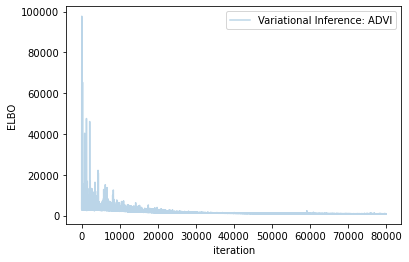

In [411]:
# we can do instead an approximated inference
n_iterations = 80_000  # start with 1000, then use 50000+
method = "advi"  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
optimizer = pm.adam  # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
learning_rate = 5e-4

with neural_network:
    approx = pm.fit(
        n_iterations,
        method=method,
        obj_optimizer=optimizer(learning_rate=learning_rate),
    )


# plot
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
plt.plot(approx.hist, label="Variational Inference: " + method.upper(), alpha=0.3)
plt.legend(loc="upper right")
plt.ylabel("ELBO")
plt.xlabel("iteration")

In [412]:
# draw samples from variational posterior
posterior_samples = 10_000
vi_posterior = approx.sample(draws=posterior_samples)

In [413]:
y_train_preds = bnn_predict(vi_posterior, X_train_bias, y_scaler)

print_evaluation(
    np.exp(y_scaler.inverse_transform(y_train)),
    y_train_preds,
    "(num+txt features) VI BNN",
)

------ (num+txt features) VI BNN model performance ------
MAE: 91,495.39
MSLE: 0.0373
RMSLE: 0.1931
MAPE: 0.1492


To generate test predictions

In [415]:
# add a column of ones to include an intercept in the model
X_test_bias = np.c_[np.ones(len(X_test)), X_test]

# predictions
y_test_preds = bnn_predict(vi_posterior, X_test_bias, y_scaler)

df_pred_bnn = pd.DataFrame(y_test_preds, columns=["Price"])
df_pred_bnn["Index"] = test_indexes
df_pred_bnn = df_pred_bnn[["Index", "Price"]]
df_pred_bnn = fix_outlier_preds(df_pred_bnn, n_std=3)
df_pred_bnn.to_csv(os.path.join(dir_path, "preds/", "num_txt_bnn_vi.csv"), index=False)

Found 21 outliers in the data with a mean Price of 2,525,317


# SUMMARY

Your summary here.